# ML @ AMSI Bioinfosummer

# Welcome
Welcome to the workshop! This notebook explores what machine learning is and walks through some common pitfalls. 
In particular, we will aim to: 
 - Discuss what machine learning may or may not be
 - Conduct some simple exploratory analysis to understand our chosen dataset/question
 - Evaluate scenarios where model performance looks great but reduces significantly on unseen data
 - Provide a passing reference to several classes of model and metrics of model performance
 - Introduce key concepts of:
     - *overfitting*
     - *training/validation/testing*
     - *hyperparameters*
 
We will not try to teach the algorithms underlying any of the models but will provide some further resources at the bottom of this notebook. 

## Assumptions

*Prior knowledge:* 
The notebook assume familiarity with python, and a passing familiarity with the pandas, matplotlib/seaborn and numpy/scipy packages. A lot of comments have been placed around the code and the expectation is you should be able to follow along rather than write this code from scratch.  

*Setup:* 
You'll need to have access to this notebook and a python 3.9 instance with 
 - pandas
 - numpy
 - sklearn
 - matplotlib
 - scipy
 







# Task 1: Exploring the data and fitting a basic model

Here, we will explore a given dataset related to diabetes and fit a basic model using the scikit-learn package. We aims to 
 - understand the dataset, its variables and their relationship. 
 - introduce the pandas-profiling and scikit-learn packages. 
 - demonstrate how to fit a model using sklearn and look at the outputs. 


## Dataset

We will be making use of a dataset of 442 diabetes patients. This is relatively small in the machine leraning space but is common (or even large) for many clinical/bioinformatis analyses. 

10 attributes have been measured:
- age age in years
- sex
- bmi body mass index
- bp average blood pressure
- tc, total serum cholesterol
- ldl, low-density lipoproteins
- hdl, high-density lipoproteins
- tch, total cholesterol / HDL
- ltg, possibly log of serum triglycerides level
- glu, blood sugar level

The target to be predicted is "a quantitative measure of disease progression one year after baseline" (Efron et al. (2004)) though  its unclear exactly what this is.

The analysis goals from this dataset are typically of a predictive task in this area: 
>Two hopes were evident [from the data], that the model would produce accurate baseline predictions of response for future patients and that the form of the model would suggest which covariates were important factors in disease progression.

Further information is available at https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset and data is taken from the original paper https://tibshirani.su.domains/ftp/lars.pdf.

We will load in the relevant packages, adjust the dataset to be a binary prediction task, whereby a poor outcome is >100) and will make some adjustments to make the column nicer more descriptive.  

In [1]:
# Setup packages and load data
# Running this cell should show the top 10 
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

def generate_diabetes_data(n_noise=2):
    # Load in the data as a data.frame, split into X (features) and y (target) 
    X,y=datasets.load_diabetes(as_frame=True, return_X_y=True)

    # Target variable is a quantitative measure of disease progression one year after baseline
    # that we dichotimise (turn into two groups) to simplify some analysis. 
    y=1*(y>100)

    # We rename the variables to be more descriptive
    X.rename({'s1': 'tc', 
              's2': 'ldl', 
              's3': 'hdl',
              's4': 'tch',
              's5': 'ltg',
              's6': 'glu',}
             , axis=1, inplace=True)
    X=(X.assign(glu2 = X['glu']+ np.random.randn(X.shape[0])/100)
       .assign(noise=1))

    if n_noise>0:
        data = np.random.randint(10, size=(5,n_noise))
        columns = ['Score E','Score F']
        df_add = pd.DataFrame(data=data,columns=columns)
        df = pd.concat([df,df_add], axis=1)
        
    return (X, y)

#Make a single data frame with the features and target to help exploration in the next section
X_y = X.assign(y = y)

### 1. 1 Data exploration
We'll begin by exploring the data that is available. While we have a description of the fields, understanding the relationships between individual features and their relationship with the outcome of interest is informative for helping to understand downstream. 

Rather than try to generate a bunch of plots manually, we can make use of a package called *pandas-profiling*, which provides a bunch of handy plots. *This will take approximately 90 seconds to run*. After that a small report below will be generated that provides an overview of the different features and their relationships. 

Try to examine the following: 

1. What are the different types of features - which are numerical? which are categorical? are any unclear?
2. Which features are correlated with each other? How strong are these?
3. Is there anything unexpected about the data?
4. Is there any missing data?
5. What does the target variable look like? What is its distribution? Are there any obvious relationships?



In [2]:
# This cell creates of the dataframe that has been entered. 

profile = ProfileReport(X_y)

profile.to_widgets()
#prof.to_notebook_iframe()

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

### Fitting a model to the data

Lets fit a simple logistic regression to the data and look at how well it makes predictions on the data. The code below will fit a simple logistic regression , using only a single predictor (bmi), to allow for simple plots of the fit, and then using all available features. 

We begin by plotting the data, the model fit and some classic summary statistics. 

*Question*:

 - Which of these outputs helps us the most to understand how useful BMI is for making decisions about future progression?
 


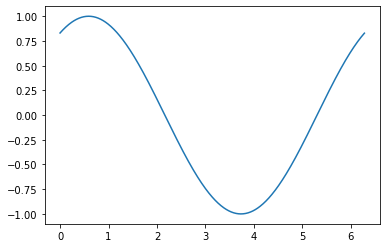

In [56]:
import statsmodels.api as sm
import seaborn as sns
from IPython.display import HTML
from celluloid import Camera # getting the camera


#The feature of interest
# Feel free to change this variable and see how this plots change
# The commented lines provide some alternatives
#features="bmi"
#features="age"
#features="glu"
#features= X.columns
features= X.columns

# Fit a logistic regression model, using the statsmodels package so we can get standard statistical output
# sklearn has the same model (sklearn.linear_model.LogisticRegression) but doesn't provide common
# statistical outputs. 

clf = sklearn.linear_model.LogisticRegression(penalty='l2').fit(X, y)
y_pred = clf.predict_proba(X.loc[:,features])
y_pred[:,0]
# Plot the distribution of predicted values for people who progress and people who don't
#sns.kdeplot(data= X_y.assign(y_pred = y_pred[:,0]), hue="y", x="y_pred")
#sns.displot(data=X_y.assign(y_pred = y_pred[:,0]), x="y_pred", hue="y", kind="hist")

import matplotlib.animation as animation


fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def animate(i):
    line.set_ydata(np.sin(x + i / 50))  # update the data.
    return line,


ani = animation.FuncAnimation(
    fig, animate, interval=20, blit=True, save_count=50)
#plt.show()
HTML(ani.to_jshtml())
## hide axes
#fig.patch.set_visible(False)
#ax.axis('off')
##ax.axis('tight')
#table = ax.table(cellText=np.round(100*X.iloc[1:3,1:3].values),
#                       colWidths = [0.25, 0.25],
#                       colLabels=X.columns[1:3],
#                       loc='right')
#
##table(cellText=np.round(100*X.iloc[1:3,1:3].values).astype(int), colLabels=X.columns[1:3], loc='center')
#table.set_fontsize(14)
#table.scale(1.5, 1.5)  # may help


In [ ]:
# Plot the distribution of BMI for people who progress and people who don't
#print(list(range(X_y.shape[0])))
##X_y.assign(id=range(X_y.size[0]))

long=pd.melt(X_y.assign(id=list(range(X_y.shape[0]))), id_vars=['id', 'y'], value_vars=X.columns)
print(long)                                                    
g = sns.FacetGrid(long, col='variable', col_order=sorted(long['variable'].unique()), col_wrap=3)
g.map(sns.boxplot, x="y", y="value", data=long, palette='muted').add_legend()


In [ ]:

# Plot the distribution of predicted values for people who progress and people who don't
print(X.loc[:,feature])
y_pred = lr.predict(X.loc[:,feature])
sns.kdeplot(data= X_y.assign(y_pred = y_pred), fill="y", x="y_pred")


-----

# Exercise 2: Overfitting and Evaluation frameworks

print("Here is some code")


We'll have a whole section on exploratory plots as that is always important. What is the data we have? What are the relationships? Worth understanding before we get started. 

## Experimental 

What if we just build model on entire dataset on the entire dataset? Get good score but doesn't give us any idea what happens when we apply to new data. Explore what happens when we add more features/have more expressive model. 

In [ ]:
clf = sklearn.linear_model.LogisticRegression(penalty='l2').fit(X, y)
pred_all=clf.predict_proba(X)[:,1]
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(y, pred_all)
auc = metrics.roc_auc_score(y, pred_all)
plt.plot(fpr,tpr,label="Train, auc={:.2f}".format(auc))
plt.legend(loc=0)

Instead, we can mimic new people by leaving out a test set. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train.shape, y_train.shape

In [ ]:
X_test.shape, y_test.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train.shape, y_train.shape

clf_all = sklearn.linear_model.LogisticRegression(penalty='l2').fit(X, y)
clf = sklearn.linear_model.LogisticRegression(penalty='l2').fit(X_train, y_train)
#clf.score(X_test, y_test)

pred_all=clf_all.predict_proba(X)[:,1]

pred_train=clf.predict_proba(X_train)[:,1]
pred_test=clf.predict_proba(X_test)[:,1]


plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(y, pred_all)
auc = metrics.roc_auc_score(y, pred_all)
plt.plot(fpr,tpr,label="All, auc={:.2f}".format(auc))

fpr, tpr, thresh = metrics.roc_curve(y_train, pred_train)
auc = metrics.roc_auc_score(y_train, pred_train)
plt.plot(fpr,tpr,label="Train, auc={:.2f}".format(auc))


fpr, tpr, thresh = metrics.roc_curve(y_test, pred_test)
auc = metrics.roc_auc_score(y_test, pred_test)
plt.plot(fpr,tpr,label="Test, auc={:.2f}".format(auc))



plt.legend(loc=0)

Performs drops on unseen individuals. 

# Overfitting and Hyperparameters
Its a big deal

In [ ]:
def make_polynomial_data(weight, n_samples=100, seed=42):
    """
    Creates noisy polynomial data.
    Args:
        weight (array): polynomial weights in descending order
        n_samples (int): number of samples
        seed (int): random seed
    returns:
        x (array): x-values
        y (array): y-values
    """
    np.random.seed(seed)

    # generate random points on the x axis
    x = (0.5-np.random.rand(n_samples))*2

    # sort the array
    x = np.sort(x)

    # evalute polynomial with weight w at positions x
    y_true = np.polyval(weight, x)

    # add noise samples from the normal gaussian
    # distribution to the data.
    y = y_true + np.random.randn(n_samples)

    return x, y




weights = np.array([10, 0, -5, 0])
X, y = make_polynomial_data(weights, n_samples=100)
scatter_plot_polynomial(X, y, label='data', title="Polynomial data")
plt.show()